# Primer voor de mogelijkheden van data-analyse met behulp van SNOMED en ECL queries.
#### Maintained by mertens@nictiz.nl
Hoewel soms omslachtig, is deze code relatief leesbaar en begrijpelijk voor lezers zonder uitgebreide ervaring met R, en bruikbaar voor demonstraties. Vragen of meer uitleg nodig? Mail me op bovenstaand adres.
Verbeteringen, verzoeken, additionele voorbeelden of nieuwe usecases zijn zeer welkom. Mocht deze code je op een of andere wijze geholpen hebben hoor ik dit graag.

De patiëntdata waar in dit script naar verwezen wordt is afkomstig van Synthea (https://github.com/synthetichealth/synthea), en moet zelf gegenereerd worden. Plaats de output van Synthea in ~/r/synthea/.

Aangezien deze code de URL naar een development Snowstorm server bevat; deze code niet verspreiden zonder voorafgaande toestemming van de auteur. Na verwijdering van de verwijzing naar de testserver snowstorm.test-nictiz.nl is verspreiding natuurlijk geen probleem. Het heeft de sterke voorkeur om zelf een Snowstorm server te draaien om overbelasting van deze development server te voorkomen. Ook is deze server regelmatig offline en bevat ongeverifiëerde data.

# Installeren benodigde libraries

In [ ]:
#Require the package so you can use it
install.packages("jsonlite");
install.packages("httr");
install.packages("urltools");
install.packages("ggplot2");
install.packages("gridExtra");
install.packages("svMisc");
install.packages("dplyr");
install.packages("repr");

require("jsonlite")
require("httr")
require("urltools")
require("svMisc")
library("ggplot2")
library("grid")
library("gridExtra")
library("plyr")
library("dplyr")
library("repr")

# Definiëren Snowstorm functies

In [2]:
# Retrieve descendants through ECL query
# CAVE - ECL queries require multiple requests for retrieving more than 10000 concepts, this function does not support this at the moment.
snowstorm_descendants <- function(conceptid){
  base <- "https://snowstorm.test-nictiz.nl/"
  branch <- "MAIN/SNOMEDCT-NL"
  endpoint <- "concepts"
  ecl <- paste("<<",conceptid,sep="")
  # Combineer alle variabelen tot een URL
  call <- paste(base,URLencode(branch),"/",endpoint,"?ecl=",URLencode(ecl),"&offset=0&limit=10000",sep="")
  
  # HTTP request met headers NL en JSON
  # Debug with verbose: get_descendants <- GET(call,verbose(),add_headers('Accept-Language' = "nl", 'Accept' = "application/json"))
  get_descendants <- GET(call,add_headers('Accept-Language' = "nl", 'Accept' = "application/json"))
  
  # Haal content op uit http request
  get_descendants_text <- content(get_descendants, "text")
  get_descendants_text
  
  descendants <- fromJSON(get_descendants_text, flatten = TRUE)
  #DEBUG View(descendants$items)
  
  # Select ID en FSN uit dataframe
  descendants_selection <- descendants$items[6:7]
  
  # Opruimen
  get_descendants <- NULL
  get_descendants_text <- NULL
  descendants <- NULL
  return(descendants_selection)
}
# ECL query without operators
# CAVE - ECL queries require multiple requests for retrieving more than 10000 concepts, this function does not support this at the moment.
snowstorm_ecl <- function(ecl){
  base <- "https://snowstorm.test-nictiz.nl/"
  branch <- "MAIN/SNOMEDCT-NL"
  endpoint <- "concepts"
  # Combineer alle variabelen tot een URL
  call <- paste(base,URLencode(branch),"/",endpoint,"?ecl=",URLencode(ecl),"&offset=0&limit=10000",sep="")
  
  # HTTP request met headers NL en JSON
  # Debug with verbose: get_descendants <- GET(call,verbose(),add_headers('Accept-Language' = "nl", 'Accept' = "application/json"))
  get_descendants <- GET(call,add_headers('Accept-Language' = "nl", 'Accept' = "application/json"))
  
  # Haal content op uit http request
  get_descendants_text <- content(get_descendants, "text")
  get_descendants_text
  
  descendants <- fromJSON(get_descendants_text, flatten = TRUE)
  #DEBUG View(descendants$items)
  
  # Select ID en FSN uit dataframe
  descendants_selection <- descendants$items[6:7]
  
  # Opruimen
  get_descendants <- NULL
  get_descendants_text <- NULL
  descendants <- NULL
  return(descendants_selection)
}
# Retrieve results through text search
# CAVE - endpoint does not support >10000 results this at the moment.
snowstorm_search <- function(query){
  base <- "https://snowstorm.test-nictiz.nl/"
  branch <- "MAIN/SNOMEDCT-NL"
  endpoint <- "concepts"
  # Combineer alle variabelen tot een URL
  call <- paste(base,URLencode(branch),"/",endpoint,"?term=",URLencode(query),"&activeFilter=true&offset=0&limit=10000",sep="")
  
  # HTTP request met headers NL en JSON
  # Debug with verbose: get_descendants <- GET(call,verbose(),add_headers('Accept-Language' = "nl", 'Accept' = "application/json"))
  get_concepts <- GET(call,add_headers('Accept-Language' = "nl", 'Accept' = "application/json"))
  
  # Haal content op uit http request
  get_concepts_text <- content(get_concepts, "text")
  get_concepts_text
  
  concepts <- fromJSON(get_concepts_text, flatten = TRUE)
  #DEBUG View(descendants$items)
  
  # Select ID en FSN uit dataframe
  concepts_selection <- concepts$items[6:7]
  
  # Opruimen
  get_concepts <- NULL
  get_concepts_text <- NULL
  concepts <- NULL
  return(concepts_selection)
}
# Functions for displaying a graph from a subset.
display_subset_imaging <- function(dataframe, conceptid, filter_empty) {
  descendants <- snowstorm_descendants(conceptid)
  print("Head")
  print(head(descendants))
  subset <- dataframe[dataframe$BODYSITE_CODE %in% descendants$id, ]
  print("Samenvatting / Summary")
  print(summary(subset[c("BODYSITE_DESCRIPTION")]))
  a <- ggplot(data = subset, aes(BODYSITE_DESCRIPTION))
  a + geom_bar() + scale_fill_discrete(drop=filter_empty) + scale_x_discrete(drop=filter_empty) + theme(axis.text.x = element_text(angle = 300,hjust = 0))
}
display_subset_conditions <- function(dataframe, conceptid, filter_empty) {
  descendants <- snowstorm_descendants(conceptid)
  print("Head")
  print(head(descendants))
  subset <- dataframe[dataframe$CODE %in% descendants$id, ]
  print("Samenvatting / Summary")
  print(summary(subset[c("DESCRIPTION")]))
  a <- ggplot(data = subset, aes(DESCRIPTION))
  a + geom_bar() + scale_fill_discrete(drop=filter_empty) + scale_x_discrete(drop=filter_empty) + theme(axis.text.x = element_text(angle = 300,hjust = 0))
}
display_subset_medications <- function(dataframe, conceptid, filter_empty) {
  descendants <- snowstorm_descendants(conceptid)
  print("Head")
  print(head(descendants))
  subset <- dataframe[dataframe$REASONCODE %in% descendants$id, ]
  print("Samenvatting / Summary")
  print(summary(subset[c("CODE","DESCRIPTION")]))
  a <- ggplot(data = subset, aes(DESCRIPTION))
  a + geom_bar() + scale_fill_discrete(drop=filter_empty) + scale_x_discrete(drop=filter_empty) + theme(axis.text.x = element_text(angle = 300,hjust = 0))
}
display_subset_encounters <- function(dataframe, conceptid, filter_empty) {
  descendants <- snowstorm_descendants(conceptid)
  print("Head")
  print(head(descendants))
  subset <- dataframe[dataframe$CODE %in% descendants$id, ]
  print("Samenvatting / Summary")
  print(summary(subset[c("CODE","DESCRIPTION")]))
  a <- ggplot(data = subset, aes(DESCRIPTION))
  a + geom_bar() + scale_fill_discrete(drop=filter_empty) + scale_x_discrete(drop=filter_empty) + theme(axis.text.x = element_text(angle = 300,hjust = 0))
}

# Inladen patiëntendata

In [3]:
imaging_studies <- read.csv(file="~/r/synthea/imaging_studies_.csv", header=TRUE, sep=";")
procedures <- read.csv(file="~/r/synthea/procedures.csv", header=TRUE, sep=",")
conditions <- read.csv(file="~/r/synthea/conditions.csv", header=TRUE, sep=",")
# medications <- read.csv(file="~/r/synthea/medications.csv", header=TRUE, sep=",")
# encounters <- read.csv(file="~/r/synthea/encounters.csv", header=TRUE, sep=",")
observations <- read.csv(file="~/r/synthea/observations.csv", header=TRUE, sep=",")
patients <- read.csv(file="~/r/synthea/patients.csv", header=TRUE, sep=",")
Sys.setlocale('LC_ALL','C')

[1] "LC_CTYPE=C;LC_NUMERIC=C;LC_TIME=C;LC_COLLATE=C;LC_MONETARY=C;LC_MESSAGES=en_US.UTF-8;LC_PAPER=en_US.UTF-8;LC_NAME=C;LC_ADDRESS=C;LC_TELEPHONE=C;LC_MEASUREMENT=en_US.UTF-8;LC_IDENTIFICATION=C"

# Tabel met beeldvorming van lichaamsdelen

## Data exploration

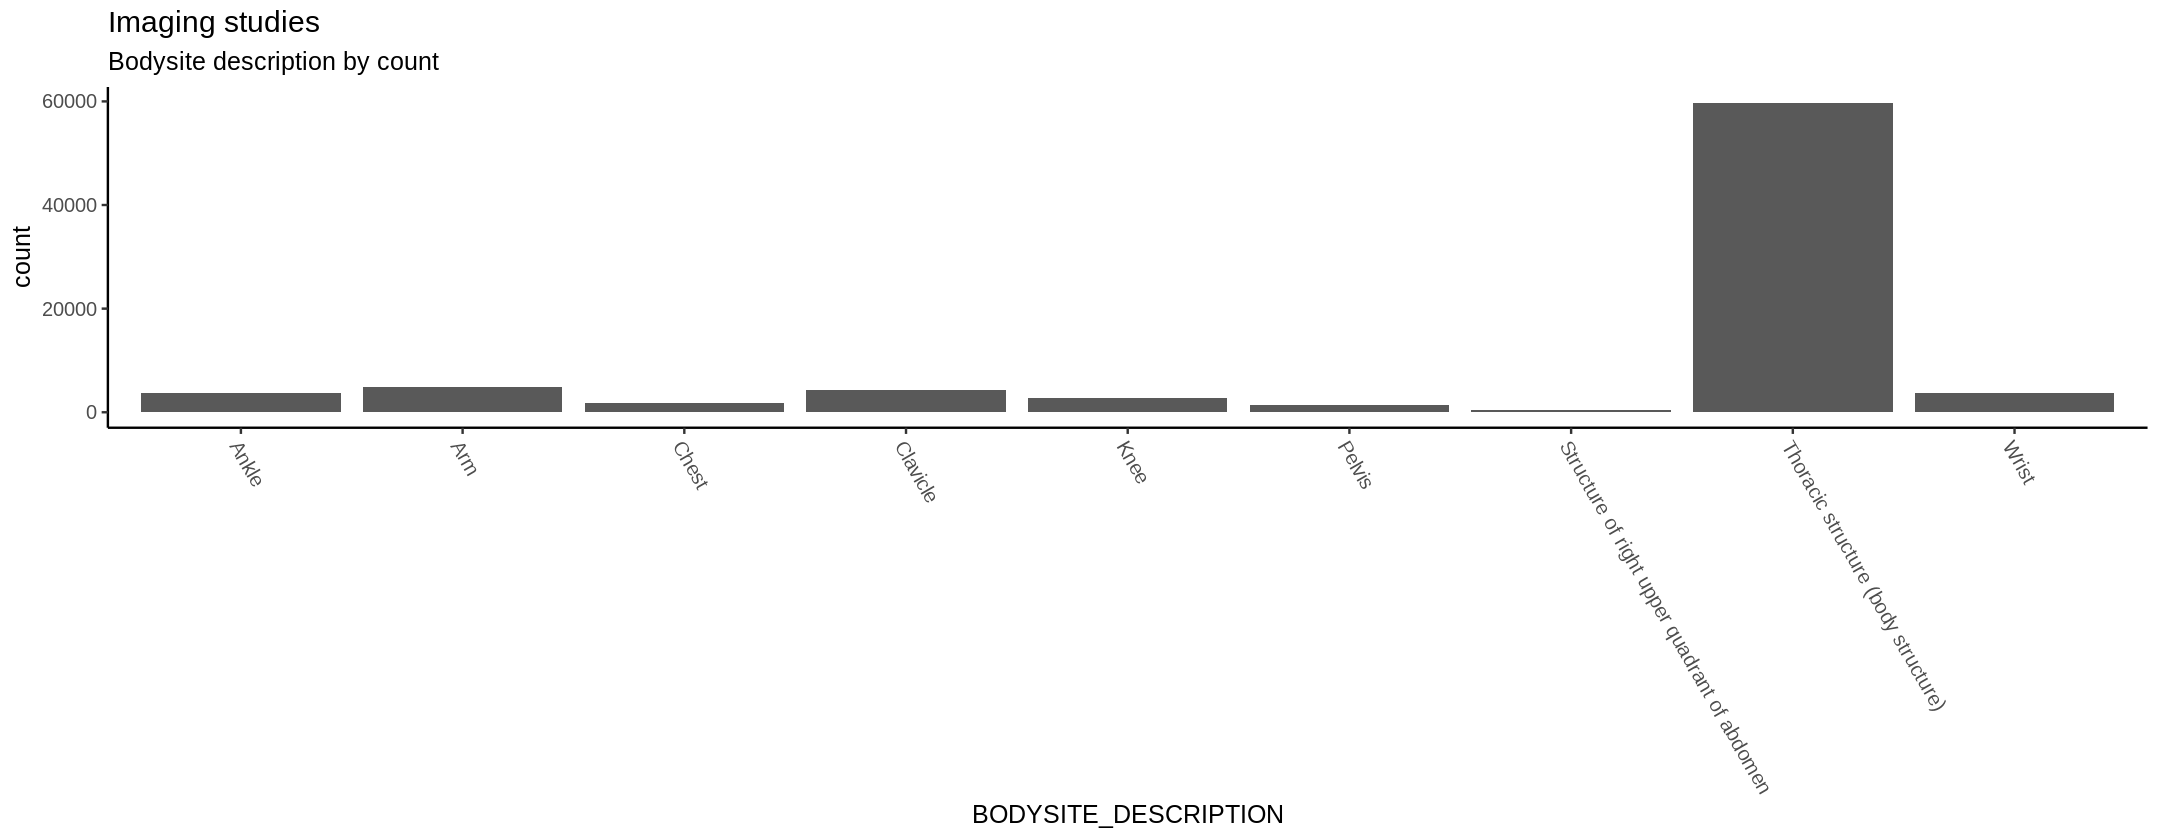

,DATE,PATIENT,ENCOUNTER,CODE,DESCRIPTION,VALUE,UNITS,TYPE
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,2010-07-20,5f17497f-76a9-49ad-b77c-5c0bee5a6dfa,db6c153e-dc49-47a7-ad77-ea5a829b75e2,8302-2,Body Height,107.7,cm,numeric
2,2011-12-29,580efa9a-7580-48af-9af6-df958de44206,a463ebc5-761f-48ce-972a-6331c7461434,8302-2,Body Height,172.4,cm,numeric
3,2010-08-30,6bd67f09-6e5d-4295-9f9b-911d49ce989d,c2c420fb-a9c0-4ead-9a57-c719b5cfc204,8302-2,Body Height,158.1,cm,numeric
4,2010-07-20,5f17497f-76a9-49ad-b77c-5c0bee5a6dfa,db6c153e-dc49-47a7-ad77-ea5a829b75e2,72514-3,Pain severity - 0-10 verbal numeric rating [Score] - Reported,2.5,{score},numeric
5,2011-12-29,580efa9a-7580-48af-9af6-df958de44206,a463ebc5-761f-48ce-972a-6331c7461434,72514-3,Pain severity - 0-10 verbal numeric rating [Score] - Reported,1.3,{score},numeric
6,2010-08-30,6bd67f09-6e5d-4295-9f9b-911d49ce989d,c2c420fb-a9c0-4ead-9a57-c719b5cfc204,72514-3,Pain severity - 0-10 verbal numeric rating [Score] - Reported,2.6,{score},numeric


"""DESCRIPTION""",n
<chr>,<int>
DESCRIPTION,25971196


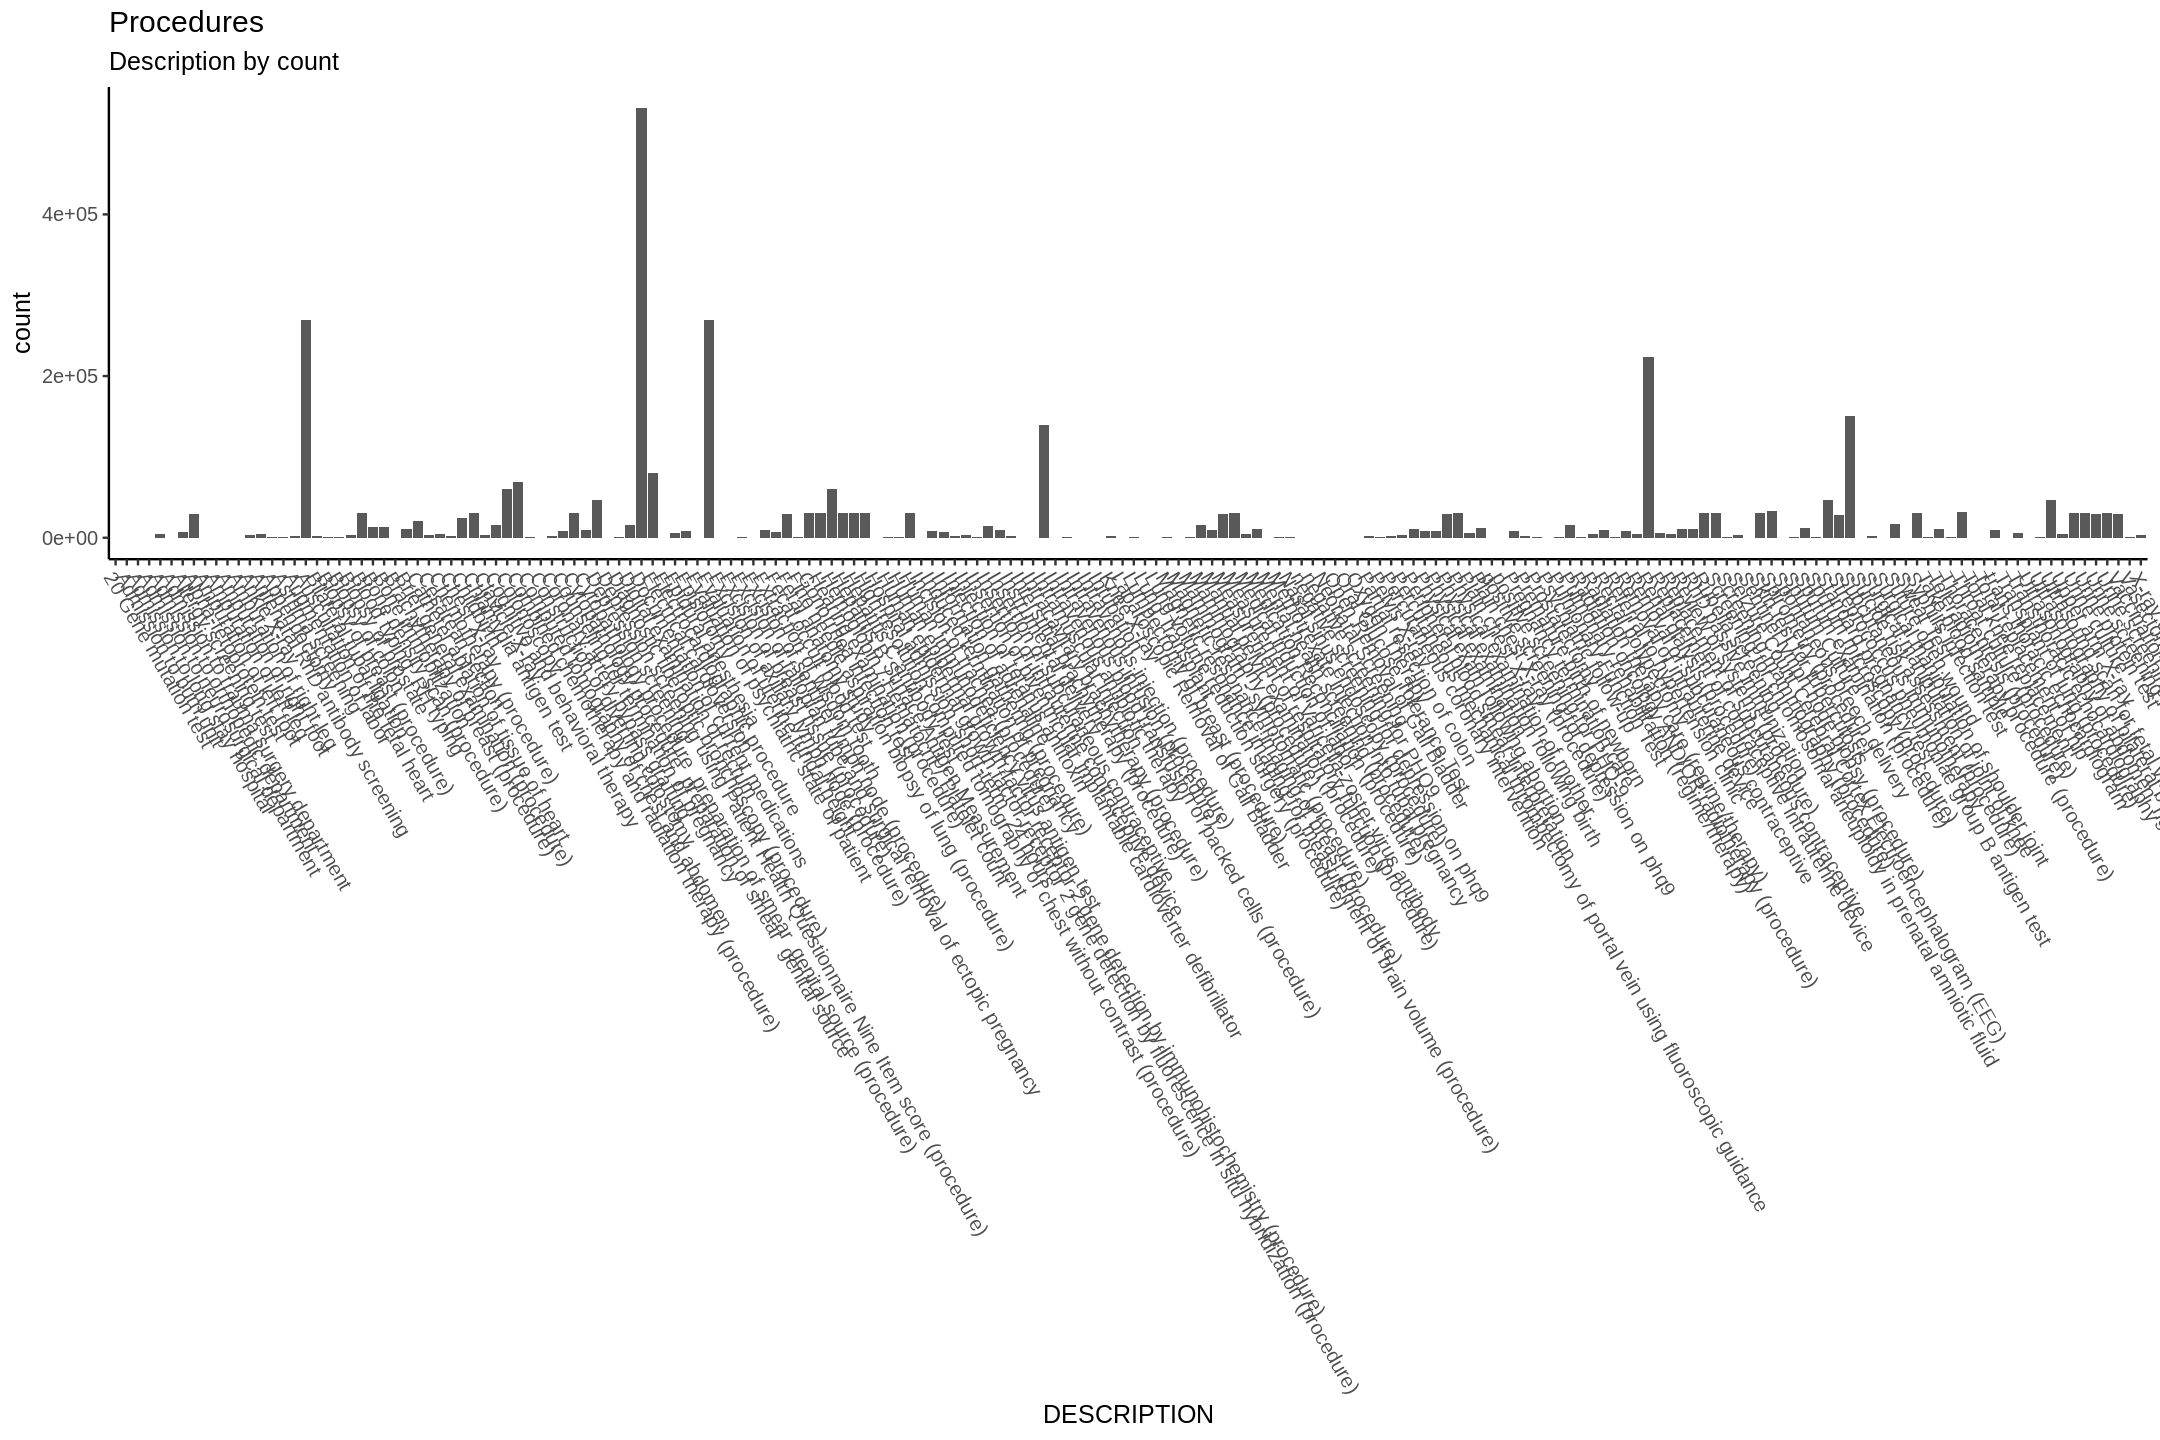

In [4]:
theme_set(theme_classic(base_size = 25))

### Imaging studies
subset = imaging_studies
options(repr.plot.width=18, repr.plot.height=7)
a <- ggplot(data = subset, aes(BODYSITE_DESCRIPTION))
a <- a + labs(title = "Imaging studies",
              subtitle = "Bodysite description by count")
a + geom_bar() + 
    scale_fill_discrete(drop=TRUE) + 
    scale_x_discrete(drop=TRUE) + 
    theme_classic(base_size = 15) +
    theme(axis.text.x = element_text(angle = 300,hjust = 0))

### Procedures
subset = procedures
options(repr.plot.width=18, repr.plot.height=12)
a <- ggplot(data = subset, aes(DESCRIPTION))
a <- a + labs(title = "Procedures",
              subtitle = "Description by count")
a + geom_bar() + 
    scale_fill_discrete(drop=TRUE) + 
    scale_x_discrete(drop=TRUE) + 
    theme_classic(base_size = 15) +
    theme(axis.text.x = element_text(angle = 300,hjust = 0))

### Measurements
head(observations)
count(observations, "DESCRIPTION")

## Aantal verrichtte beeldvormende onderzoeken per lichaamsdeel

In [5]:
imaging_studies %>% count(BODYSITE_DESCRIPTION)

BODYSITE_DESCRIPTION,n
<fct>,<int>
Ankle,3779
Arm,4873
Chest,1881
Clavicle,4327
Knee,2737
Pelvis,1385
Structure of right upper quadrant of abdomen,349
Thoracic structure (body structure),59784
Wrist,3631


## Filteren op onderste ledematen

In [6]:
snowstorm_search("onderste extr")[0:5,]

,id,fsn.term
,<chr>,<chr>
1,61685007,structuur van membrum inferius (lichaamsstructuur)
2,46528009,structuur van posterieure ledemaatknop (lichaamsstructuur)
3,241570001,computertomografie van onderste extremiteit (verrichting)
4,182281004,gehele onderste extremiteit (lichaamsstructuur)
5,32153003,structuur van linker onderste extremiteit (lichaamsstructuur)


In [7]:
# Gebruik het SCTID van het eerste resultaat van de zoekopdracht om descendants op te halen
snowstorm_descendants(snowstorm_search("onderste extre")[1,1])

,id,fsn.term
,<chr>,<chr>
1,48791000146101,Tendon of hip (body structure)
2,35971000146109,Structure of soft tissues of thigh (body structure)
3,35961000146103,Structure of soft tissues of lower leg (body structure)
4,35951000146101,Structure of soft tissues of knee (body structure)
5,35931000146107,Structure of soft tissues of foot (body structure)
6,23531000087100,Structure of tarsometatarsal joint of right third toe (body structure)
7,23521000087102,Structure of tarsometatarsal joint of left third toe (body structure)
8,23511000087105,Structure of tarsometatarsal joint of right second toe (body structure)
9,23501000087108,Structure of tarsometatarsal joint of left second toe (body structure)


In [8]:
print("Beeldvorming: Filteren op onderste ledematen (zoek op 'lower extre')")
descendants = snowstorm_descendants(snowstorm_search("lower extre")[1,1])
subset <- imaging_studies[imaging_studies$BODYSITE_CODE %in% descendants$id, ]
count(subset,BODYSITE_DESCRIPTION)

print("Beeldvorming: Filteren op bovenste ledematen (zoek op 'upper limb')")
descendants = snowstorm_descendants(snowstorm_search("upper limb")[1,1])
subset <- imaging_studies[imaging_studies$BODYSITE_CODE %in% descendants$id, ]
count(subset,BODYSITE_DESCRIPTION)

[1] "Beeldvorming: Filteren op onderste ledematen (zoek op 'lower extre')"


BODYSITE_DESCRIPTION,n
<fct>,<int>
Ankle,3779
Knee,2737


[1] "Beeldvorming: Filteren op bovenste ledematen (zoek op 'upper limb')"


BODYSITE_DESCRIPTION,n
<fct>,<int>
Arm,4873
Clavicle,4327
Wrist,3631


# ECL query - Disease + morfologie = beschadiging

In [9]:
# Descendants van ECL query op ziekten met morfologie beschadiging
descendants <- snowstorm_ecl(ecl = "
<< 64572001 |Disease (disorder)| :
  {  116676008 |gerelateerde morfologie (attribuut)| = << 37782003 |beschadiging (afwijkende morfologie)| }
")
head(descendants)

,id,fsn.term
,<chr>,<chr>
1,31580001000004106,Bilateral sacral insufficiency fracture (disorder)
2,29580001000004102,Burst fracture of ninth thoracic vertebra (disorder)
3,29120001000004103,fractuur van pediculus van vijfde cervicale wervel (aandoening)
4,29110001000004106,fractuur van pediculus van vierde cervicale wervel (aandoening)
5,28490001000004108,compressie fractuur van tweede lumbale wervel (aandoening)
6,24990001000004105,fractuur van masto<U+00EF>d (aandoening)


DESCRIPTION,n
<fct>,<int>
Bullet wound,715
Closed fracture of hip,1275
Concussion injury of brain,598
Concussion with loss of consciousness,1859
Concussion with no loss of consciousness,6883
Facial laceration,3573
First degree burn,2773
Fracture of clavicle,3844
Fracture of forearm,4607


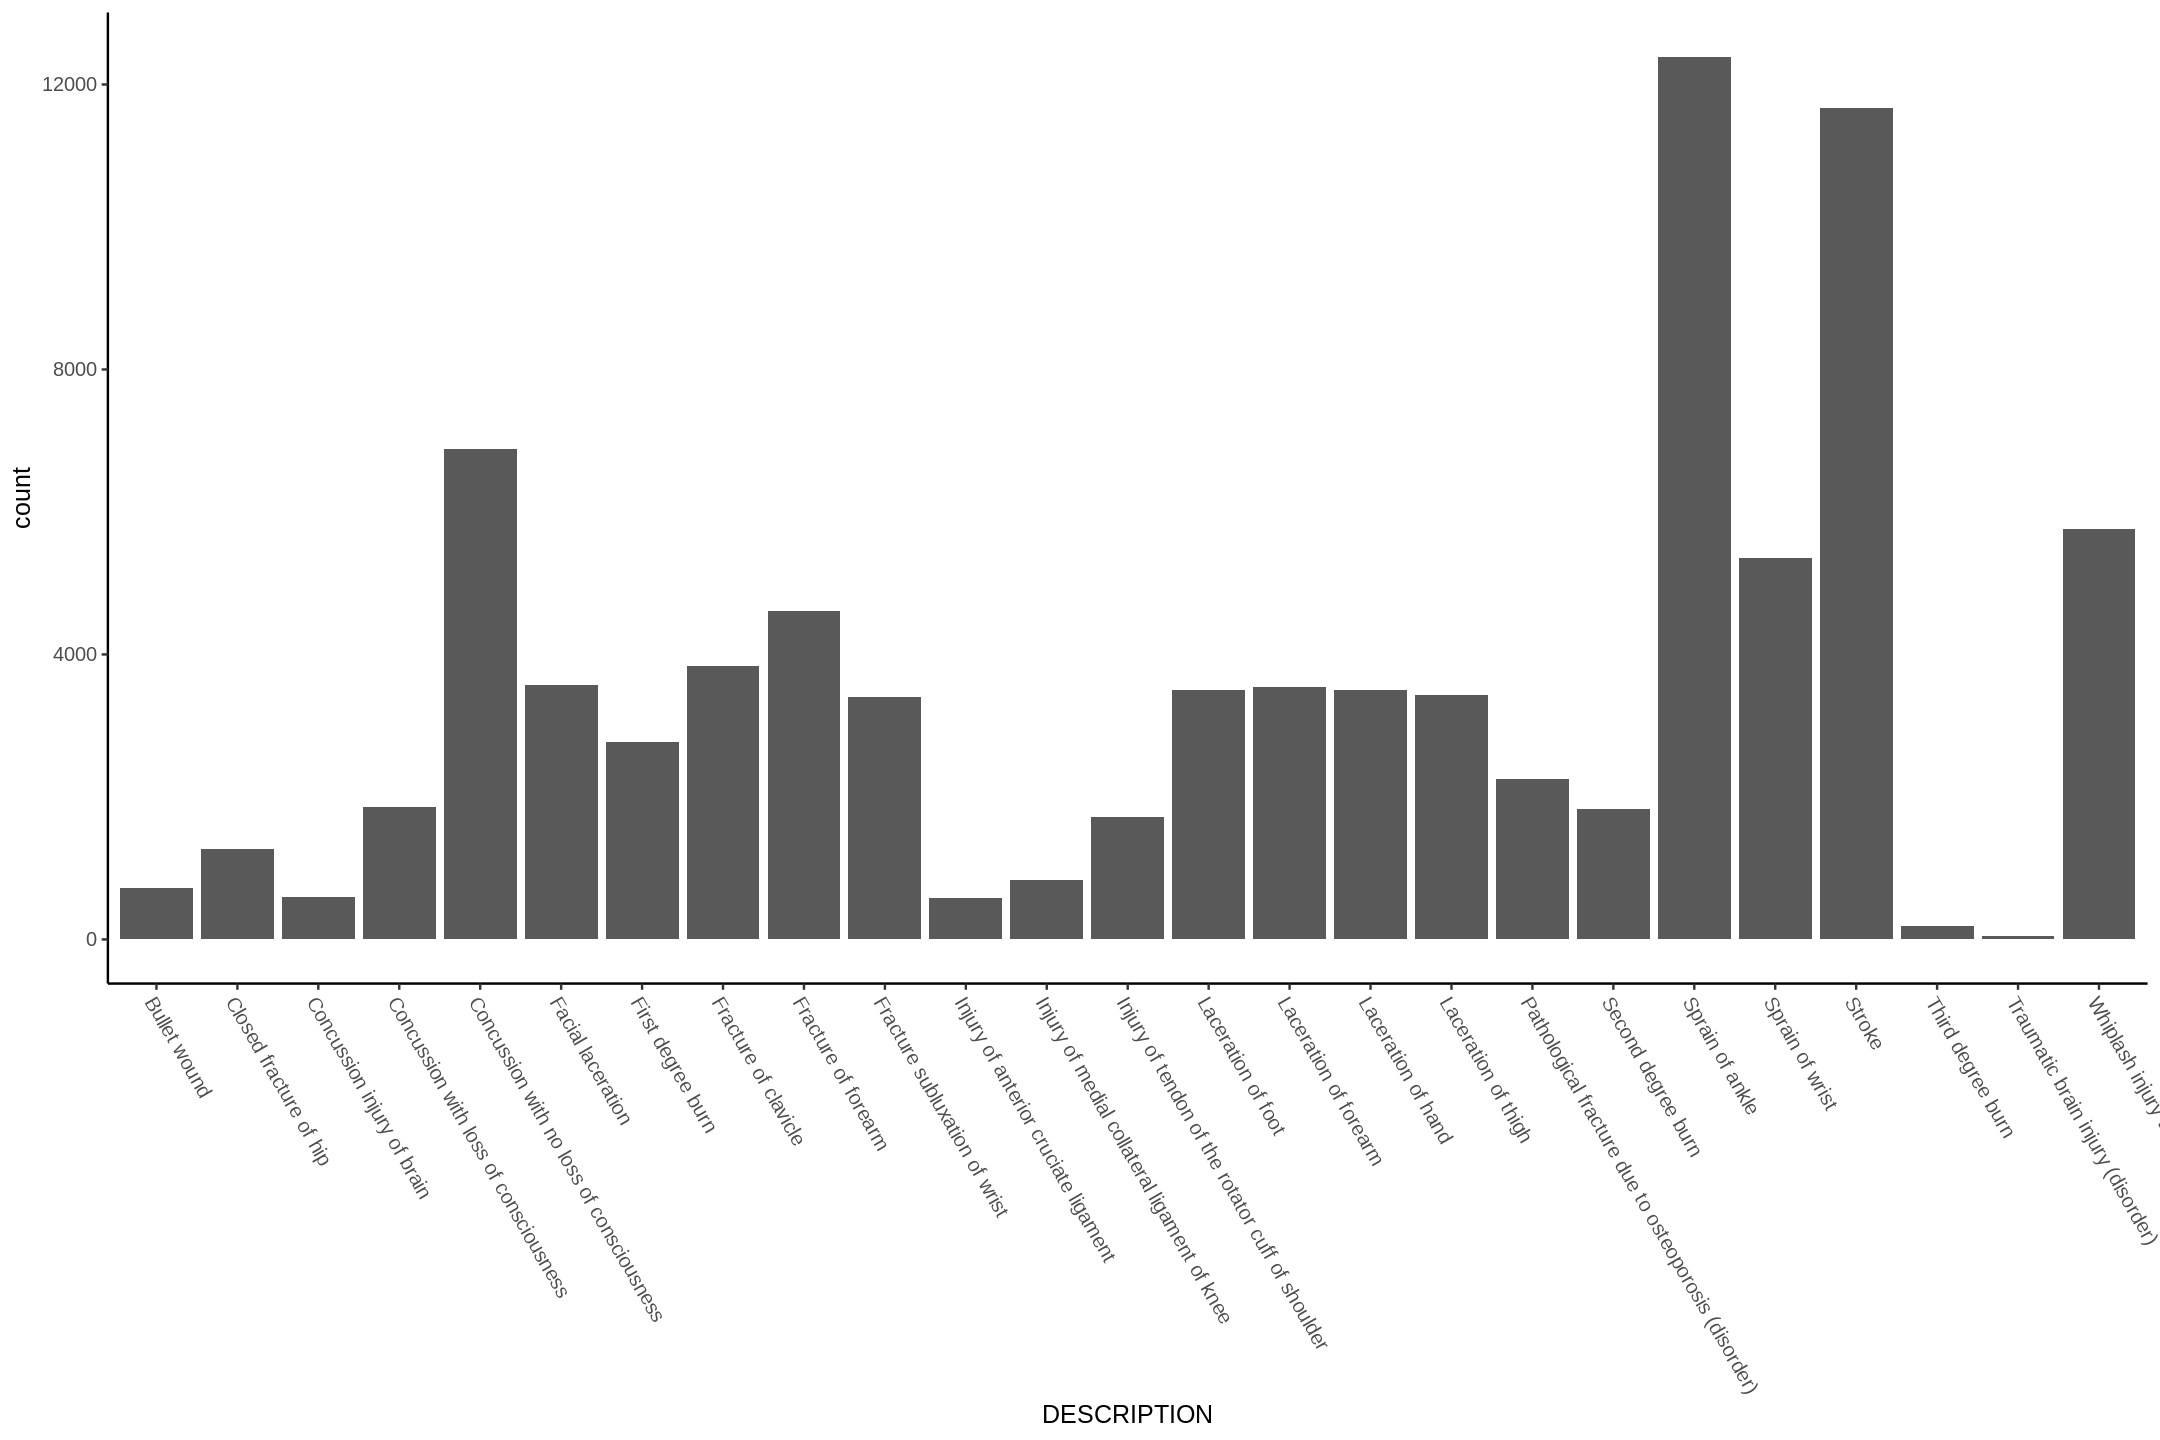

In [10]:
subset <- conditions[conditions$CODE %in% descendants$id, ]
count(subset, DESCRIPTION)
a <- ggplot(data = subset, aes(DESCRIPTION))
a + geom_bar() + 
    scale_fill_discrete(drop=TRUE) + 
    scale_x_discrete(drop=TRUE) + 
    theme_classic(base_size = 15) +
    theme(axis.text.x = element_text(angle = 300,hjust = 0))

# ECL query - Disease + locatie = hart

,id,fsn.term
,<chr>,<chr>
1,16754391000119100,Stable angina due to coronary arteriosclerosis (disorder)
2,16228931000119102,Cardiomyopathy caused by drug (disorder)
3,16025471000119107,Aneurysm of coronary artery due to and following acute febrile mucocutaneous lymph node syndrome (disorder)
4,15964981000119104,congenitale afwijking van hartholte (aandoening)
5,15964901000119107,Atypical atrial flutter (disorder)
6,15964701000119109,Acute cor pulmonale co-occurrent and due to saddle embolus of pulmonary artery (disorder)


[1] "Aantal resultaten:"
[1] 2668


DESCRIPTION,n
<fct>,<int>
Atrial Fibrillation,4339
Cardiac Arrest,8756
Chronic congestive heart failure (disorder),5638
Coronary Heart Disease,6730
Myocardial Infarction,4850


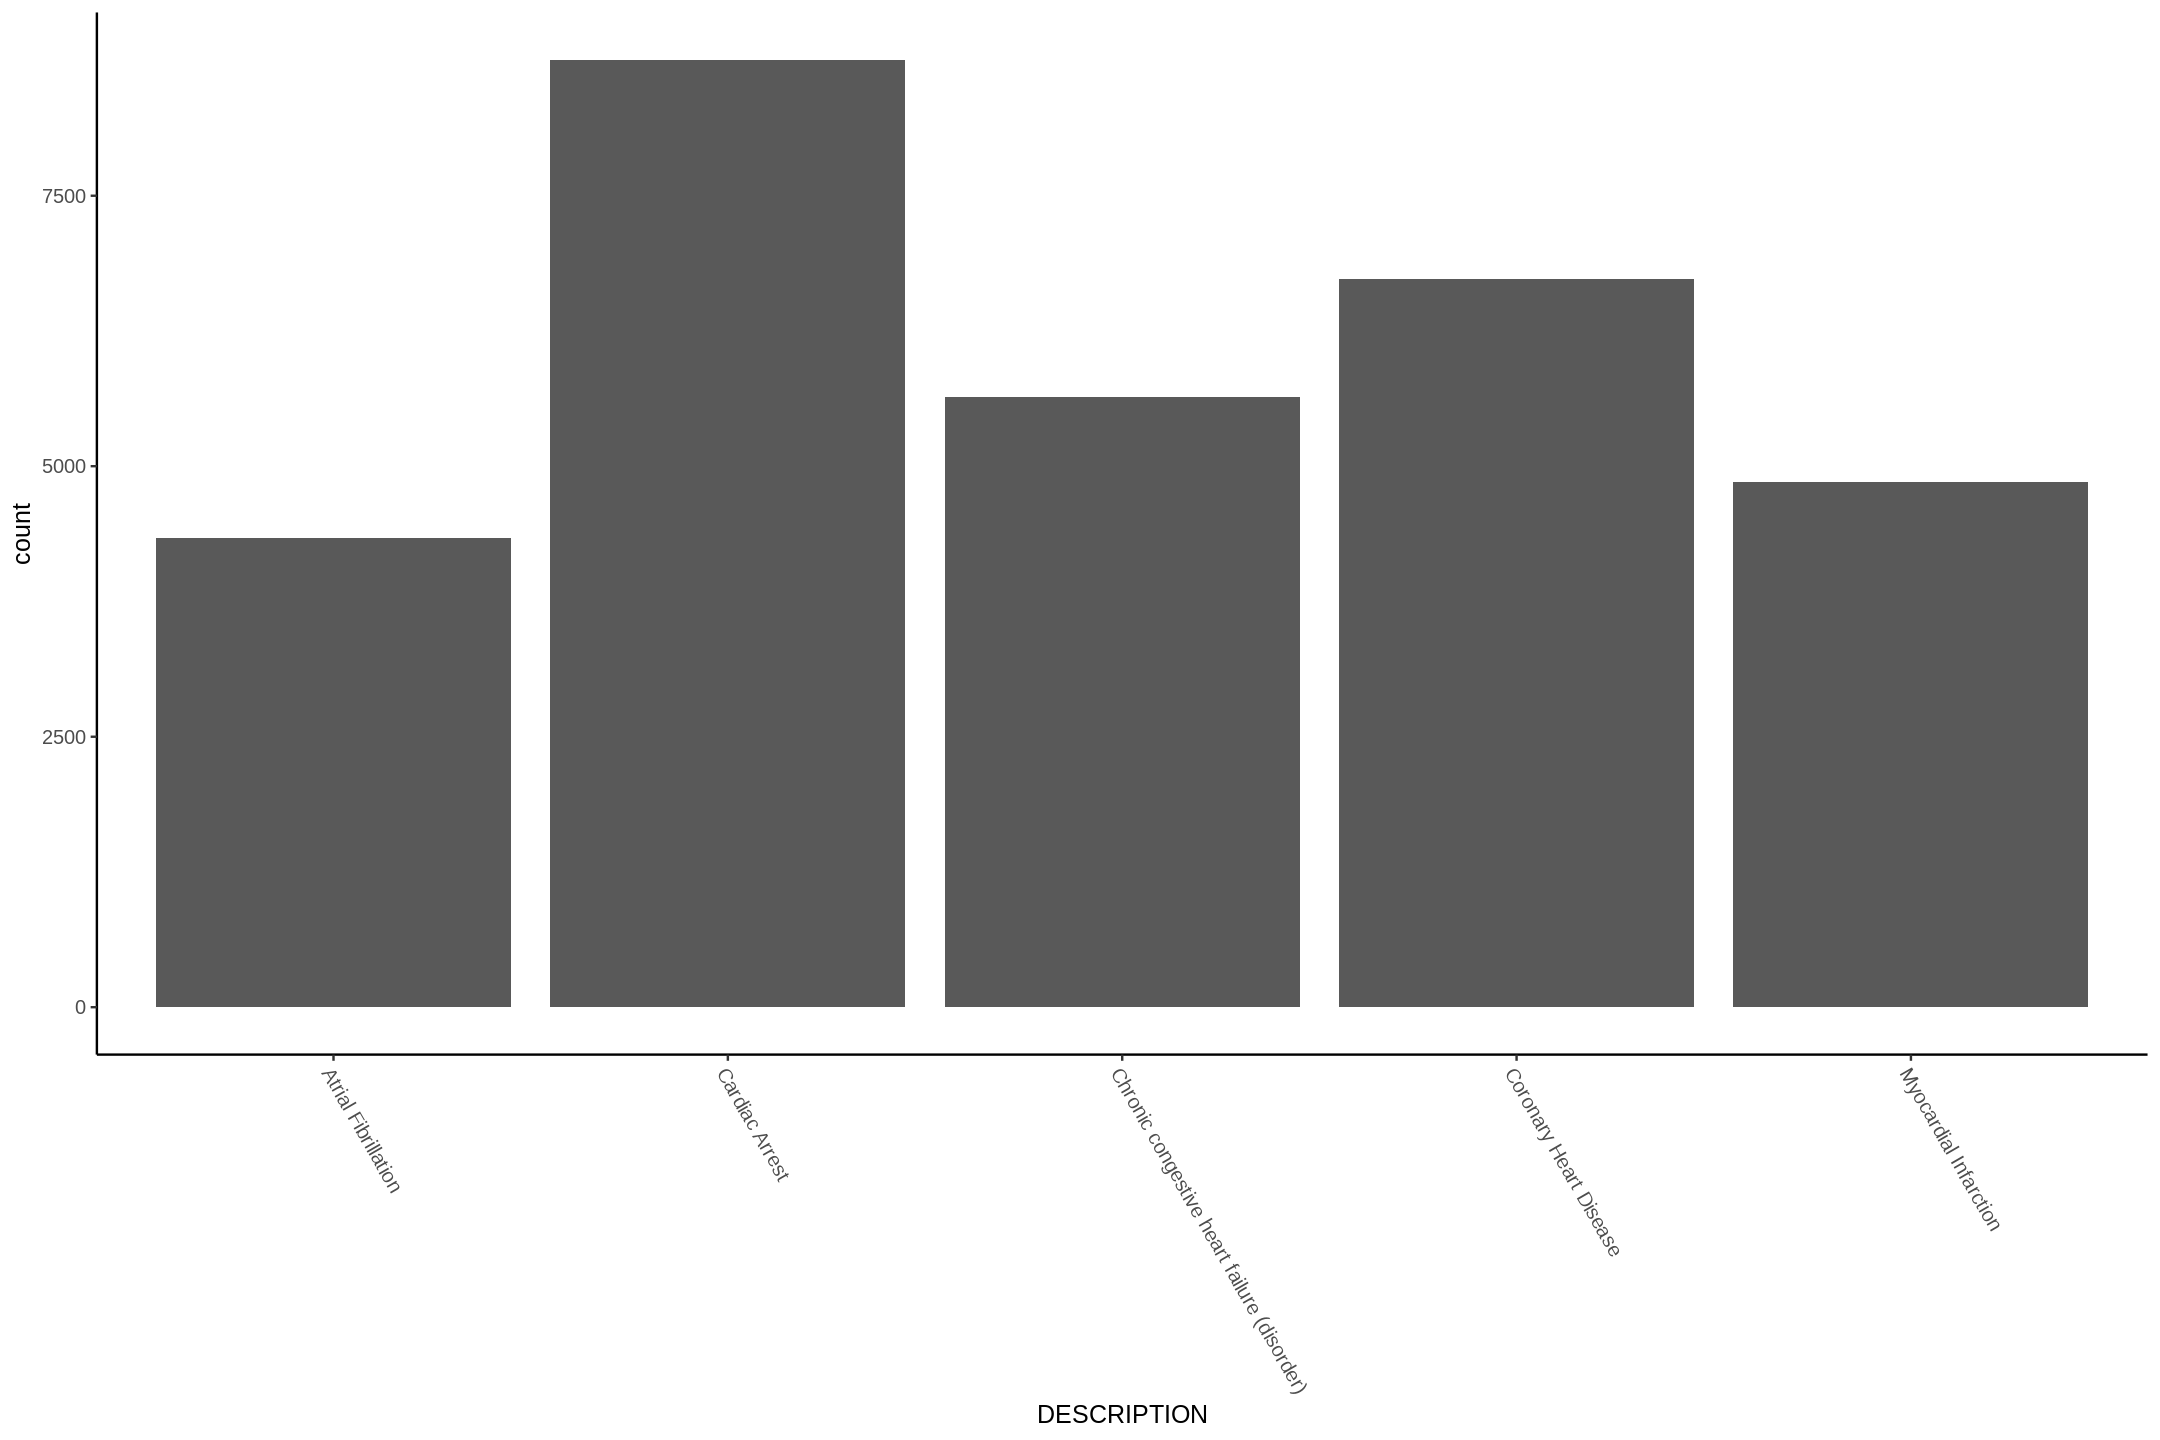

In [11]:
# Descendants van ziekten met locatie 'hart'
descendants <- snowstorm_ecl(ecl = "
<< 64572001 |Disease (disorder)| : 
{  363698007 |locatie van bevinding (attribuut)| = << 80891009 |structuur van cor (lichaamsstructuur)| }
")

head(descendants)
print('Aantal resultaten:')
print(length(unique(descendants$id)))

# Maak subset obv filter descendants$id
subset <- conditions[conditions$CODE %in% descendants$id, ]

# Print incidentie
count(subset,DESCRIPTION)

a <- ggplot(data = subset, aes(DESCRIPTION))
a + geom_bar() + 
    scale_fill_discrete(drop=TRUE) + 
    scale_x_discrete(drop=TRUE) + 
    theme_classic(base_size = 15) +
    theme(axis.text.x = element_text(angle = 300,hjust = 0))

In [12]:
# Descendants van ziekten van het hart met morfologie acuut infarct
descendants <- snowstorm_ecl(ecl = "
<< 64572001 |Disease (disorder)| : 
{  
  << 363698007 |locatie van bevinding (attribuut)| = << 80891009 |structuur van cor (lichaamsstructuur)| AND
  << 116676008 |gerelateerde morfologie (attribuut)| = << 55470003 |acuut infarct (afwijkende morfologie)|
}")

head(descendants)

,id,fsn.term
,<chr>,<chr>
1,15713201000119105,acuut myocardinfarct van posterobasale wand met ST-segmentelevatie (aandoening)
2,15713161000119100,acuut myocardinfarct van septum met ST-segmentelevatie (aandoening)
3,15713121000119105,acuut myocardinfarct met ST-segmentelevatie door occlusie van rechter coronairarterie (aandoening)
4,15713081000119108,acuut myocardinfarct met ST-segmentelevatie door occlusie van linker coronairarterie (aandoening)
5,15713041000119103,acuut myocardinfarct van achterwand met ST-segmentelevatie (aandoening)
6,15712961000119108,acuut myocardinfarct van anteroseptale wand met ST-segmentelevatie (aandoening)


# BMI & diabetes

In [13]:
df <- observations

# Subset -> only BMI (LOINC 39156-5 = BMI)
df_bmi <- df[df$CODE == '39156-5',]
df_bmi <- df_bmi[1:10000,]
nrow(count(df_bmi, PATIENT))
df_bmi$VALUE <- as.numeric(as.character(df_bmi$VALUE))

# Nieuw dataframe met alleen patiënten waarvan het BMI bekend is
head(df_bmi)
df_avg_bmi <- ddply( df_bmi, .(PATIENT), function(x) mean(x$VALUE) )
names(df_avg_bmi)[names(df_avg_bmi) == "V1"] <- "avg_bmi"

[1] 1146

,DATE,PATIENT,ENCOUNTER,CODE,DESCRIPTION,VALUE,UNITS,TYPE
,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>
10,2010-07-20,5f17497f-76a9-49ad-b77c-5c0bee5a6dfa,db6c153e-dc49-47a7-ad77-ea5a829b75e2,39156-5,Body Mass Index,15.5,kg/m2,numeric
11,2011-12-29,580efa9a-7580-48af-9af6-df958de44206,a463ebc5-761f-48ce-972a-6331c7461434,39156-5,Body Mass Index,26.9,kg/m2,numeric
12,2010-08-30,6bd67f09-6e5d-4295-9f9b-911d49ce989d,c2c420fb-a9c0-4ead-9a57-c719b5cfc204,39156-5,Body Mass Index,31.1,kg/m2,numeric
30,2012-09-10,6df948f6-8d93-40ae-87e9-d9ed0a6f0f64,2b22ac69-7c48-411e-8d1f-1ee43e81013e,39156-5,Body Mass Index,30.2,kg/m2,numeric
35,2015-01-01,580efa9a-7580-48af-9af6-df958de44206,aa04da2a-c20e-411e-9068-b2eeacaa74ea,39156-5,Body Mass Index,28.8,kg/m2,numeric
66,2011-07-26,5f17497f-76a9-49ad-b77c-5c0bee5a6dfa,2f7de2a5-9601-4dbe-9791-a6a3d3f7988e,39156-5,Body Mass Index,15.5,kg/m2,numeric


In [14]:
patients_df <- patients
patients_df$PATIENT <- patients_df$Id
patients_df$bmi <- NULL
patients_df$comorb_diabetes <- NULL
patients_df <- merge(patients_df, df_avg_bmi, by="PATIENT")
head(patients_df)
count(patients_df[patients_df$avg_bmi > 0,])

,PATIENT,Id,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,FIRST,LAST,⋯,ADDRESS,CITY,STATE,COUNTY,ZIP,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,avg_bmi
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,006f57ba-d170-4d9d-941f-0b2fe67784be,006f57ba-d170-4d9d-941f-0b2fe67784be,1961-12-02,2014-12-09,999-88-7746,S99946001,X12662737X,Mrs.,Jenneken942,Wielinga944,⋯,422 Boonstra Row,Easton,Massachusetts,Bristol County,NA,42.11109,-71.09280,1102447.83,13052.38,29.65556
2,00856429-3b59-4305-8796-9bc91cadedde,00856429-3b59-4305-8796-9bc91cadedde,1942-01-08,,999-54-6944,S99973853,X63275196X,Mr.,Maria750,van den Pol381,⋯,522 Tamminga Alley Unit 80,West Springfield,Massachusetts,Hampden County,1089,42.18477,-72.58551,50848.79,2392.36,28.30000
3,00d6d09a-9417-4355-82d2-e0d3e1271553,00d6d09a-9417-4355-82d2-e0d3e1271553,1966-05-18,,999-22-9398,S99926650,X3013675X,Mrs.,Gisela897,Braaksma460,⋯,1066 Scholten Street,Brewster,Massachusetts,Barnstable County,2631,41.84571,-70.00896,982154.14,8988.20,29.18571
4,00f17b19-0afe-42f9-acad-e77424568d8b,00f17b19-0afe-42f9-acad-e77424568d8b,2014-05-18,,999-59-3377,,,,Micha632,Huizinga285,⋯,291 Geertsma Path,Boston,Massachusetts,Suffolk County,2108,42.41836,-70.97913,143421.10,1808.24,14.32000
5,00fea86e-00ad-4440-9d85-3c60e7c2b4f7,00fea86e-00ad-4440-9d85-3c60e7c2b4f7,2000-12-13,,999-62-5528,S99977329,,Ms.,Leila837,van der Velden628,⋯,693 Kalsbeek Row Apt 66,Westford,Massachusetts,Middlesex County,NA,42.67802,-71.37696,498912.27,2717.32,15.76667
6,0161d91f-6c08-48c4-81ce-608ee5d1e06d,0161d91f-6c08-48c4-81ce-608ee5d1e06d,1978-03-21,,999-75-1821,S99942029,X69712532X,Ms.,Philomena945,Elzinga474,⋯,1070 Halma Street Apt 87,Waltham,Massachusetts,Middlesex County,2451,42.47405,-71.15310,1069783.91,4648.76,25.70000


n
<int>
1146


In [15]:
ecl_results <- snowstorm_ecl(ecl = "
    << 73211009 |diabetes mellitus (aandoening)|
")
nrow(ecl_results)
ecl_results


# patients_w_diabetes

[1] 326

,id,fsn.term
,<chr>,<chr>
1,530558861000132104,Atypical diabetes mellitus (disorder)
2,10754881000119104,diabetes mellitus bij moeder als complicatie bij bevalling (aandoening)
3,10753491000119101,diabetes gravidarum tijdens bevalling (aandoening)
4,368741000119105,Moderate nonproliferative retinopathy co-occurrent and due to secondary diabetes mellitus (disorder)
5,368721000119104,Nonproliferative retinopathy co-occurrent and due to secondary diabetes mellitus (disorder)
6,368711000119106,Mild nonproliferative retinopathy co-occurrent and due to secondary diabetes mellitus (disorder)
7,368581000119106,Neuropathy due to type 2 diabetes mellitus (disorder)
8,368521000119107,Disorder of nerve co-occurrent and due to type 1 diabetes mellitus (disorder)
9,367261000119100,Hyperosmolarity co-occurrent and due to drug induced diabetes mellitus (disorder)


In [16]:
# Wel / geen diabetes in dataset verwerken
diseases <- conditions

patients_df$comorb = 0

for (row in 1:nrow(patients_df)) {
    cur_pt <- as.character(patients_df[row,'Id'])
    condition_filtered <- as.character(diseases[diseases$PATIENT == cur_pt, 'CODE'])
    # Aandoeningen checken
    for(condition in condition_filtered){
        if(condition %in% ecl_results$id){
            patients_df[patients_df$Id == cur_pt, 'comorb'] <- 1
        }
    }
    
}

patients_df$comorb <- factor(patients_df$comorb, levels = c(0,1), labels = c("Geen comorbiditeit", "Wel comorbiditeit"))

# head(patients)
# patients_df[1:10, c('FIRST','LAST','comorb','avg_bmi')]
patients_df[1:10,]

,PATIENT,Id,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,FIRST,LAST,⋯,CITY,STATE,COUNTY,ZIP,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,avg_bmi,comorb
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,006f57ba-d170-4d9d-941f-0b2fe67784be,006f57ba-d170-4d9d-941f-0b2fe67784be,1961-12-02,2014-12-09,999-88-7746,S99946001,X12662737X,Mrs.,Jenneken942,Wielinga944,⋯,Easton,Massachusetts,Bristol County,NA,42.11109,-71.09280,1102447.83,13052.38,29.65556,Geen comorbiditeit
2,00856429-3b59-4305-8796-9bc91cadedde,00856429-3b59-4305-8796-9bc91cadedde,1942-01-08,,999-54-6944,S99973853,X63275196X,Mr.,Maria750,van den Pol381,⋯,West Springfield,Massachusetts,Hampden County,1089,42.18477,-72.58551,50848.79,2392.36,28.30000,Geen comorbiditeit
3,00d6d09a-9417-4355-82d2-e0d3e1271553,00d6d09a-9417-4355-82d2-e0d3e1271553,1966-05-18,,999-22-9398,S99926650,X3013675X,Mrs.,Gisela897,Braaksma460,⋯,Brewster,Massachusetts,Barnstable County,2631,41.84571,-70.00896,982154.14,8988.20,29.18571,Geen comorbiditeit
4,00f17b19-0afe-42f9-acad-e77424568d8b,00f17b19-0afe-42f9-acad-e77424568d8b,2014-05-18,,999-59-3377,,,,Micha632,Huizinga285,⋯,Boston,Massachusetts,Suffolk County,2108,42.41836,-70.97913,143421.10,1808.24,14.32000,Geen comorbiditeit
5,00fea86e-00ad-4440-9d85-3c60e7c2b4f7,00fea86e-00ad-4440-9d85-3c60e7c2b4f7,2000-12-13,,999-62-5528,S99977329,,Ms.,Leila837,van der Velden628,⋯,Westford,Massachusetts,Middlesex County,NA,42.67802,-71.37696,498912.27,2717.32,15.76667,Geen comorbiditeit
6,0161d91f-6c08-48c4-81ce-608ee5d1e06d,0161d91f-6c08-48c4-81ce-608ee5d1e06d,1978-03-21,,999-75-1821,S99942029,X69712532X,Ms.,Philomena945,Elzinga474,⋯,Waltham,Massachusetts,Middlesex County,2451,42.47405,-71.15310,1069783.91,4648.76,25.70000,Geen comorbiditeit
7,018581b8-30b9-44bb-a705-eeab6415a587,018581b8-30b9-44bb-a705-eeab6415a587,1989-03-15,,999-71-7680,S99934870,X80256810X,Mr.,Jay242,Blom544,⋯,Boston,Massachusetts,Suffolk County,2108,42.34975,-70.93827,663817.07,3049.68,23.83333,Geen comorbiditeit
8,01930a44-d097-4fd2-b15a-8345be0b84f0,01930a44-d097-4fd2-b15a-8345be0b84f0,1942-04-26,,999-52-8101,S99957674,X4355755X,Mr.,Felipe97,Gamboa193,⋯,Lawrence,Massachusetts,Essex County,1840,42.70690,-71.09391,1762839.79,10609.60,28.00000,Geen comorbiditeit
9,028af869-6130-4d5b-933c-15e702beecd3,028af869-6130-4d5b-933c-15e702beecd3,1970-01-22,,999-58-7985,S99930988,X7201677X,Mrs.,Micaela928,Far<ed>as160,⋯,Worcester,Massachusetts,Worcester County,1545,42.28840,-71.80319,1035972.49,11617.85,29.41667,Geen comorbiditeit


In [17]:
# T-test
table_df = patients_df
aggregate(data = table_df, avg_bmi ~ comorb, mean)
t.test(table_df$avg_bmi~table_df$comorb)

comorb,avg_bmi
<fct>,<dbl>
Geen comorbiditeit,25.25339
Wel comorbiditeit,28.04865



	Welch Two Sample t-test

data:  table_df$avg_bmi by table_df$comorb
t = -6.6123, df = 106.54, p-value = 1.551e-09
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -3.633329 -1.957198
sample estimates:
mean in group Geen comorbiditeit  mean in group Wel comorbiditeit 
                        25.25339                         28.04865 


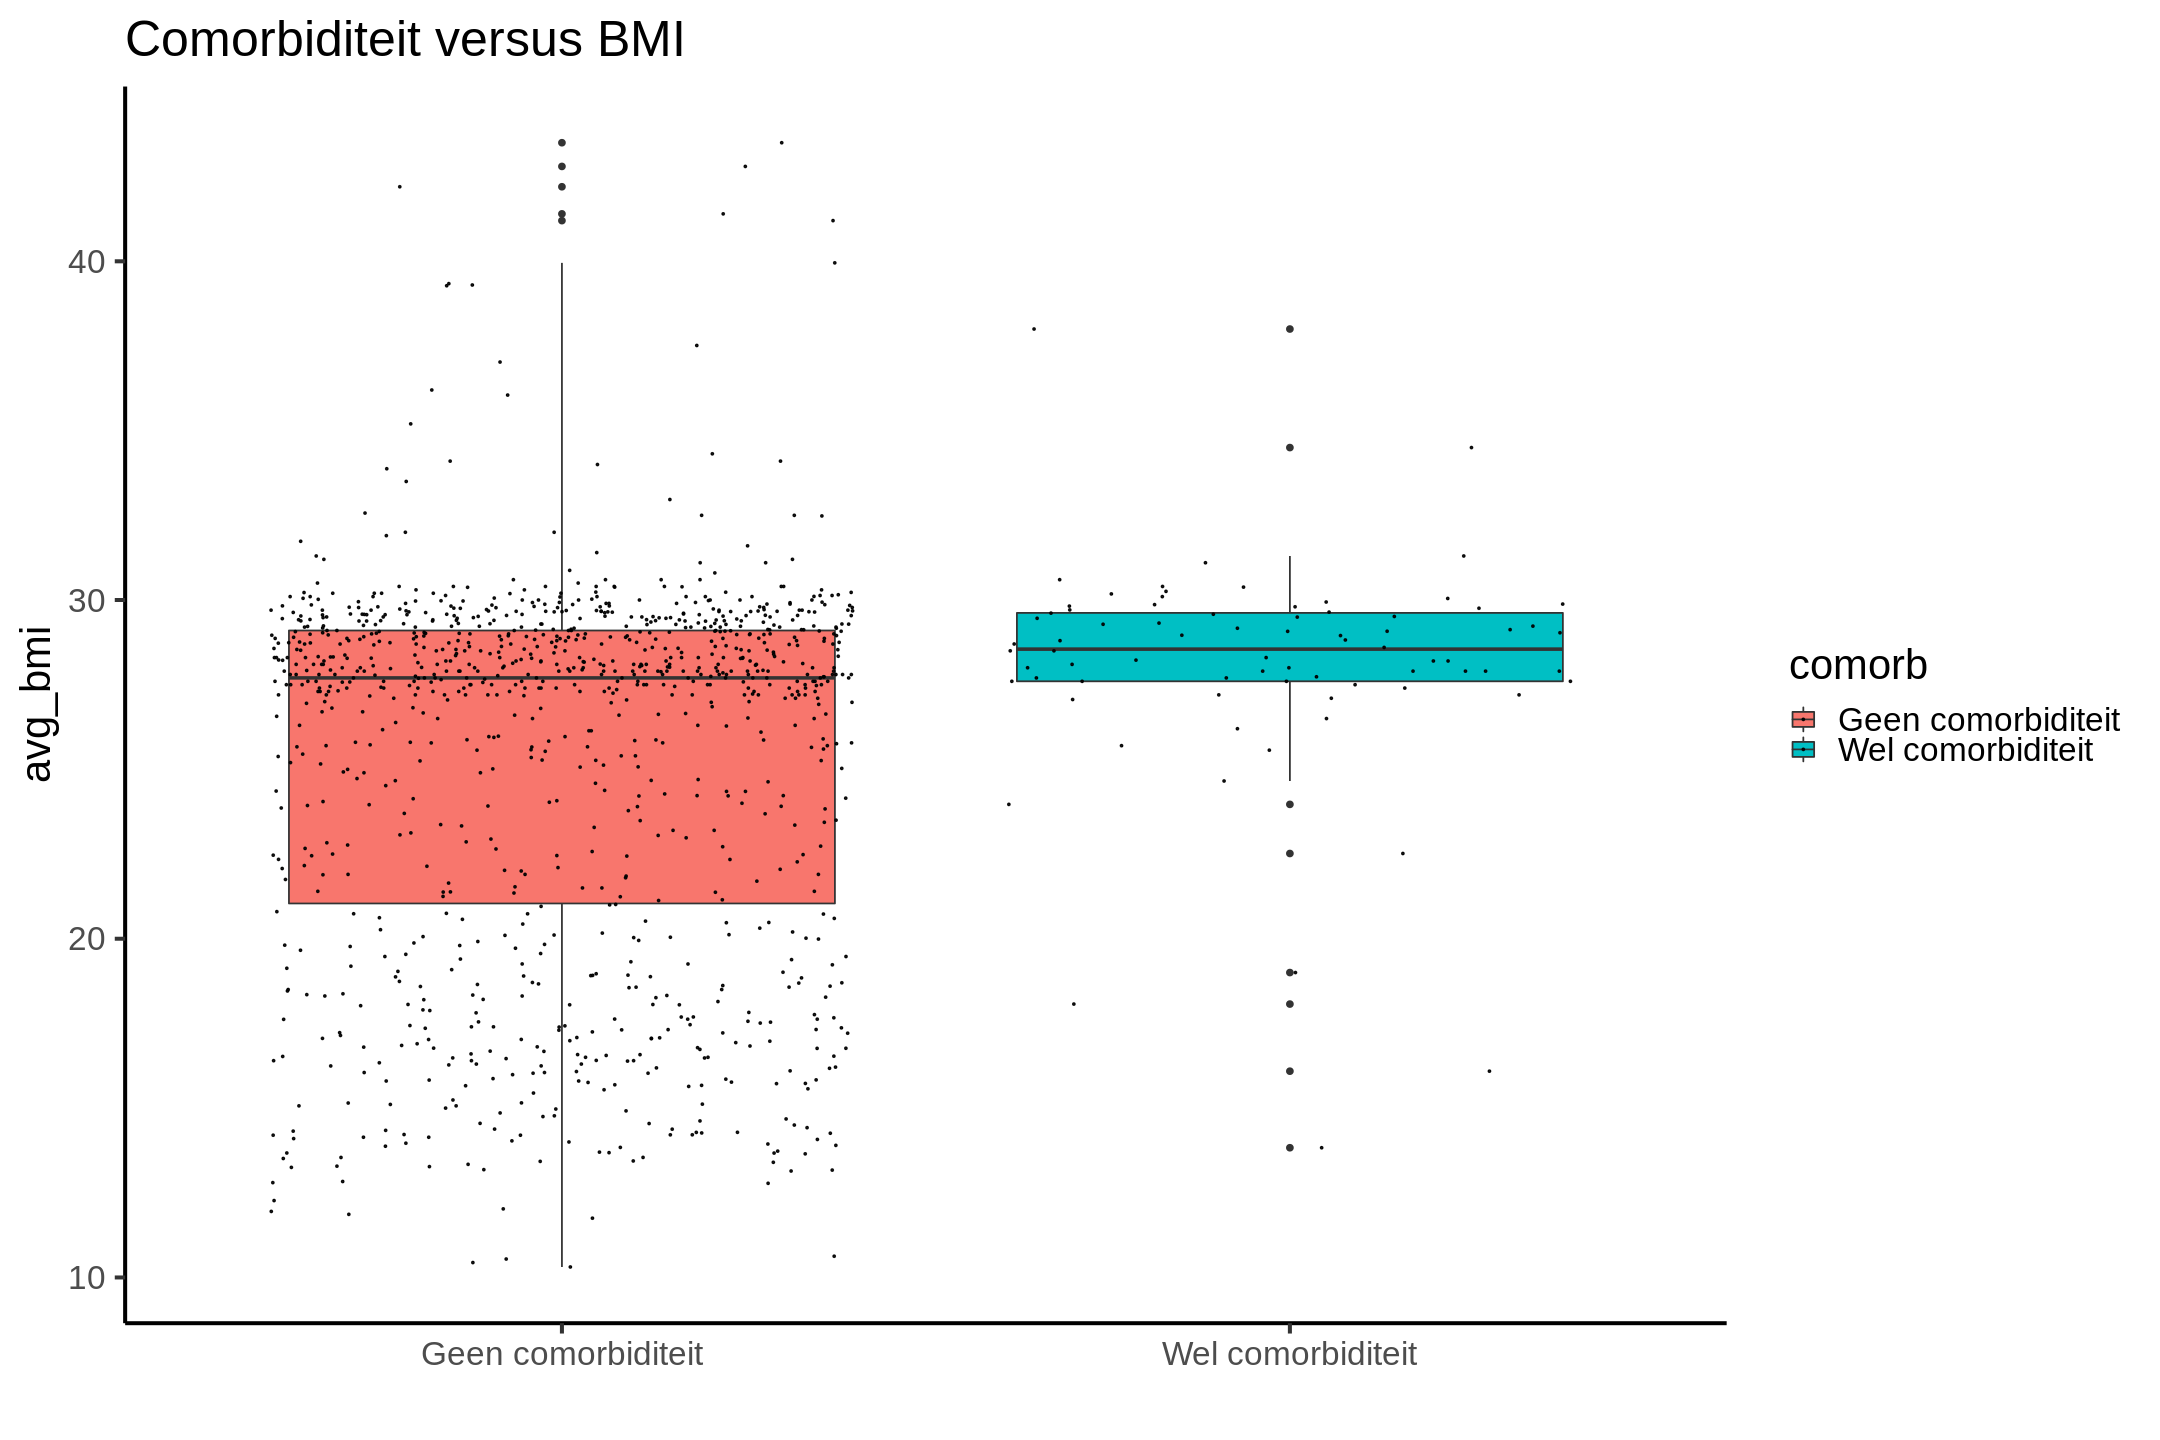

In [18]:
# Grafiek
table_df %>%
  ggplot( aes(x=comorb, y=avg_bmi, fill=comorb)) +
    geom_boxplot() +
    geom_jitter(color="black", size=0.4, alpha=0.9) +
    ggtitle("Comorbiditeit versus BMI") +
    xlab("")